In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

PROJECT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
RAW = PROJECT / "data" / "raw"
INTERIM = PROJECT / "data" / "interim"
RAW.mkdir(parents=True, exist_ok=True)
INTERIM.mkdir(parents=True, exist_ok=True)


csv_path = RAW / "accepted_2007_to_2018Q4.csv"




cols = [
    "loan_status", "purpose",
    "loan_amnt", "term", "int_rate", "installment",
    "grade", "sub_grade", "emp_length",
    "annual_inc", "dti",
    "open_acc", "total_acc", "revol_util", "delinq_2yrs"
]


df = pd.read_csv(
    csv_path,
    usecols=lambda c: c in cols,   
    nrows=100_000,                 
    low_memory=False
)

print("shape:", df.shape)
df.head()


shape: (100000, 15)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,purpose,dti,delinq_2yrs,open_acc,revol_util,total_acc
0,3600.0,36 months,13.99,123.03,C,C4,10+ years,55000.0,Fully Paid,debt_consolidation,5.91,0.0,7.0,29.7,13.0
1,24700.0,36 months,11.99,820.28,C,C1,10+ years,65000.0,Fully Paid,small_business,16.06,1.0,22.0,19.2,38.0
2,20000.0,60 months,10.78,432.66,B,B4,10+ years,63000.0,Fully Paid,home_improvement,10.78,0.0,6.0,56.2,18.0
3,35000.0,60 months,14.85,829.90,C,C5,10+ years,110000.0,Current,debt_consolidation,17.06,0.0,13.0,11.6,17.0
4,10400.0,60 months,22.45,289.91,F,F1,3 years,104433.0,Fully Paid,major_purchase,25.37,1.0,12.0,64.5,35.0


In [9]:

missing = df.isnull().sum().sort_values(ascending=False)
print(missing.head(10))


print("Duplicate rows:", df.duplicated().sum())


emp_length     6112
revol_util       37
dti               2
loan_amnt         0
term              0
int_rate          0
installment       0
grade             0
sub_grade         0
annual_inc        0
dtype: int64
Duplicate rows: 0


In [11]:
df["loan_status"].value_counts(normalize=True) * 100


loan_status
Fully Paid            70.288
Charged Off           17.603
Current               11.402
Late (31-120 days)     0.441
In Grace Period        0.199
Late (16-30 days)      0.066
Default                0.001
Name: proportion, dtype: float64

In [15]:

keep = ["Fully Paid", "Charged Off", "Default"]
df = df[df["loan_status"].isin(keep)].copy()
df["target"] = df["loan_status"].map({"Fully Paid": 0, "Charged Off": 1, "Default": 1})

print(df["loan_status"].value_counts(normalize=True).rename("class_%"))



loan_status
Fully Paid     0.799709
Charged Off    0.200280
Default        0.000011
Name: class_%, dtype: float64


In [17]:

df["int_rate"] = pd.to_numeric(
    df["int_rate"].astype(str).str.replace("%", "", regex=False),
    errors="coerce"
)

df["revol_util"] = pd.to_numeric(
    df["revol_util"].astype(str).str.replace("%", "", regex=False),
    errors="coerce"
)


emp_map = {
    "10+ years": 10, "9 years": 9, "8 years": 8, "7 years": 7, "6 years": 6,
    "5 years": 5, "4 years": 4, "3 years": 3, "2 years": 2, "1 year": 1,
    "< 1 year": 0, "n/a": np.nan
}
df["emp_length"] = df["emp_length"].map(emp_map).astype("float64")


In [19]:
na = df.isna().sum().sort_values(ascending=False)
print("top missing:\n", na.head(10))
print("duplicates:", df.duplicated().sum())


top missing:
 emp_length     5629
revol_util       36
dti               2
loan_amnt         0
term              0
int_rate          0
installment       0
grade             0
sub_grade         0
annual_inc        0
dtype: int64
duplicates: 0


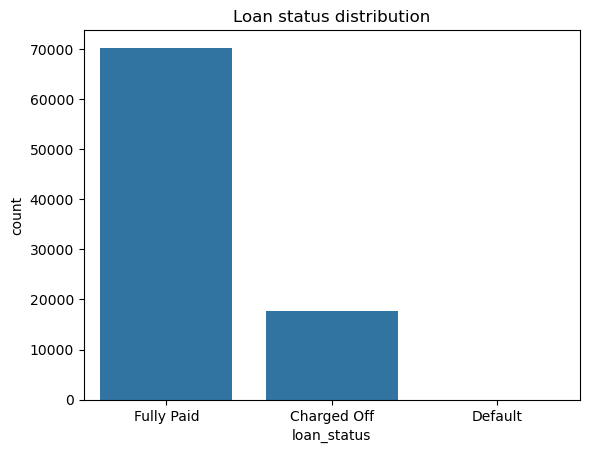

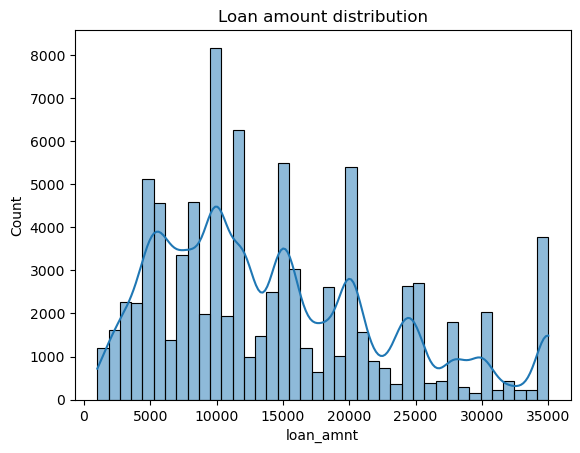

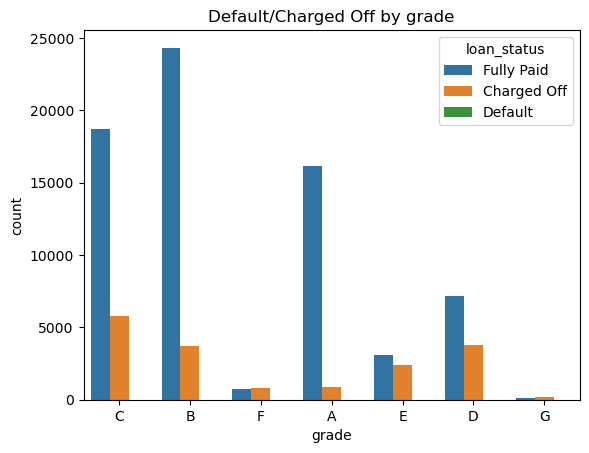

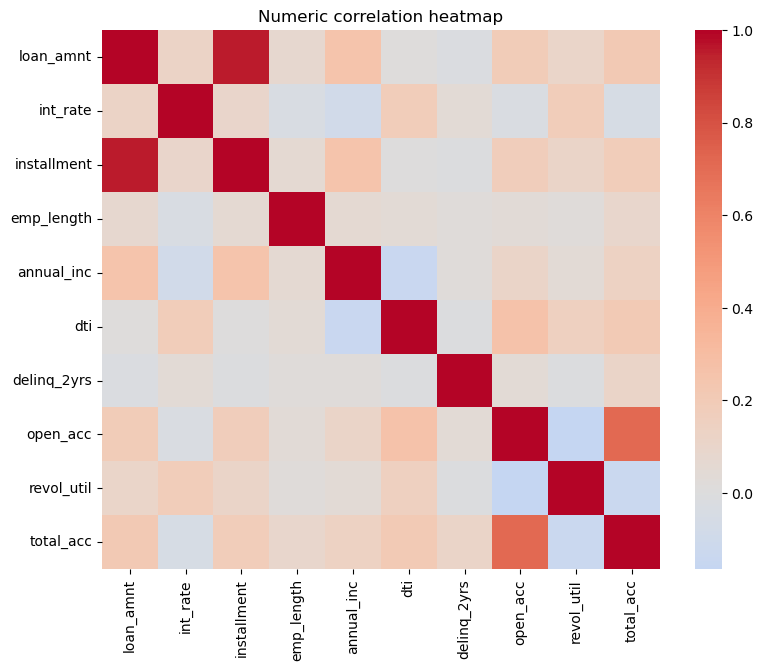

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x="loan_status")
plt.title("Loan status distribution")
plt.show()

sns.histplot(df["loan_amnt"], bins=40, kde=True)
plt.title("Loan amount distribution")
plt.show()

sns.countplot(data=df, x="grade", hue="loan_status")
plt.title("Default/Charged Off by grade")
plt.show()

num = df.select_dtypes(include=[np.number]).drop(columns=["target"])
plt.figure(figsize=(9,7))
sns.heatmap(num.corr(), cmap="coolwarm", center=0)
plt.title("Numeric correlation heatmap")
plt.show()


In [23]:
status_map = {
    "Fully Paid": 0,
    "Charged Off": 1,
    "Default": 1,
    "Late (31-120 days)": 1,
    "Late (16-30 days)": 1,
    "In Grace Period": 1,
    "Current": np.nan  # drop these rows
}

df["target"] = df["loan_status"].map(status_map)
df = df.dropna(subset=["target"])   # remove Current loans
df["target"] = df["target"].astype(int)

print(df["target"].value_counts(normalize=True) * 100)


target
0    79.970873
1    20.029127
Name: proportion, dtype: float64


In [25]:
num_cols = ["loan_amnt","int_rate","installment","annual_inc",
            "dti","revol_util","emp_length","open_acc","total_acc","delinq_2yrs"]
cat_cols = ["term","grade","sub_grade","purpose"]

work = df[num_cols + cat_cols + ["target"]].copy()
work.shape


(87892, 15)

In [27]:

for c in num_cols:
    work[c] = work[c].astype(float)
    work[c] = work[c].fillna(work[c].median())


In [29]:
for c in cat_cols:
    work[c] = work[c].astype(str).fillna("Unknown")


In [31]:
work.isna().sum().sort_values(ascending=False).head()


loan_amnt      0
int_rate       0
installment    0
annual_inc     0
dti            0
dtype: int64

In [33]:
X_num = work[num_cols].copy()
X_cat = pd.get_dummies(work[cat_cols], drop_first=True)
X = pd.concat([X_num, X_cat], axis=1)
y = work["target"].astype(int)
X.shape, y.shape


((87892, 62), (87892,))

In [35]:
from pathlib import Path
PROCESSED = (Path.cwd().parents[0] if Path.cwd().name=="notebooks" else Path.cwd()) / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

X.to_parquet(PROCESSED/"X_structured.parquet")
y.to_frame("target").to_parquet(PROCESSED/"y.parquet")


In [37]:
list(X.columns[:10]), X.head(3)


(['loan_amnt',
  'int_rate',
  'installment',
  'annual_inc',
  'dti',
  'revol_util',
  'emp_length',
  'open_acc',
  'total_acc',
  'delinq_2yrs'],
    loan_amnt  int_rate  installment  annual_inc    dti  revol_util  \
 0     3600.0     13.99       123.03     55000.0   5.91        29.7   
 1    24700.0     11.99       820.28     65000.0  16.06        19.2   
 2    20000.0     10.78       432.66     63000.0  10.78        56.2   
 
    emp_length  open_acc  total_acc  delinq_2yrs  ...  \
 0        10.0       7.0       13.0          0.0  ...   
 1        10.0      22.0       38.0          1.0  ...   
 2        10.0       6.0       18.0          0.0  ...   
 
    purpose_debt_consolidation  purpose_home_improvement  purpose_house  \
 0                        True                     False          False   
 1                       False                     False          False   
 2                       False                      True          False   
 
    purpose_major_purchase  purp

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(70313, 62) (17579, 62)


In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)


In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [47]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]   


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.6611297570965357
Precision: 0.32974559686888455
Recall: 0.6699801192842942
F1: 0.4419672131147541
ROC-AUC: 0.726421343087543


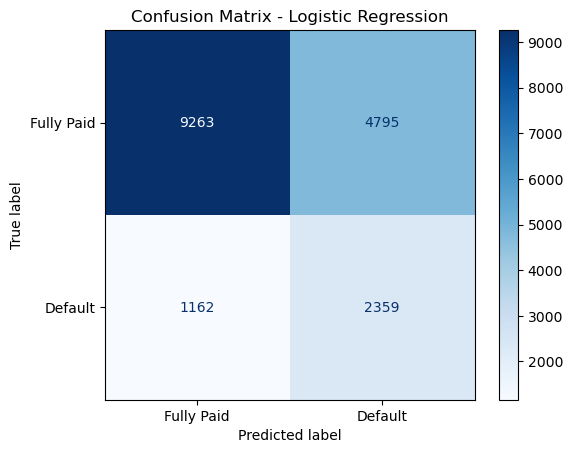

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fully Paid", "Default"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


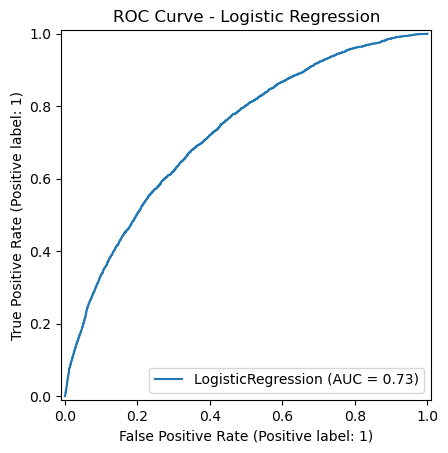

In [53]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()


In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,       
    max_depth=None,         
    class_weight="balanced",
    random_state=42,
    n_jobs=-1               
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [57]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.7999886227885545
Precision: 0.5032765399737876
Recall: 0.10905992615734167
F1: 0.1792717086834734
ROC-AUC: 0.7106818471727607


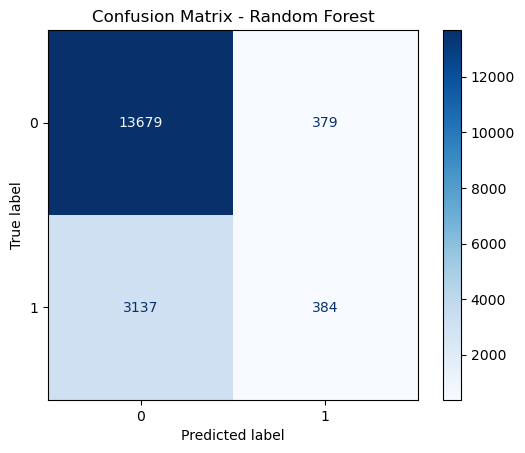

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()




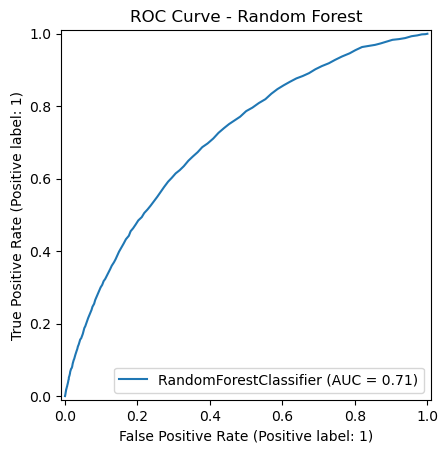

In [63]:

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

In [65]:


import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)
import matplotlib.pyplot as plt
import numpy as np




In [67]:

pos = y_train.sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos
scale_pos_weight


3.9927572250230776

In [73]:




xgb_clf = xgb.XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",           # <-- set here (constructor)
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)



In [75]:
xgb_clf.fit(X_train, y_train)   


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.6806985607827521
Precision: 0.3412264723740134
Recall: 0.6384549843794377
F1: 0.44475220100900187
ROC-AUC: 0.7241557665772937


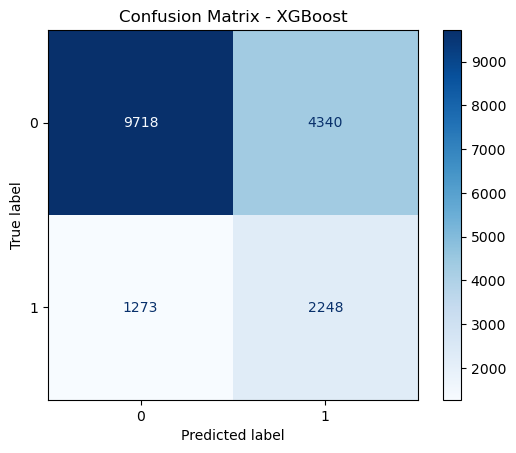

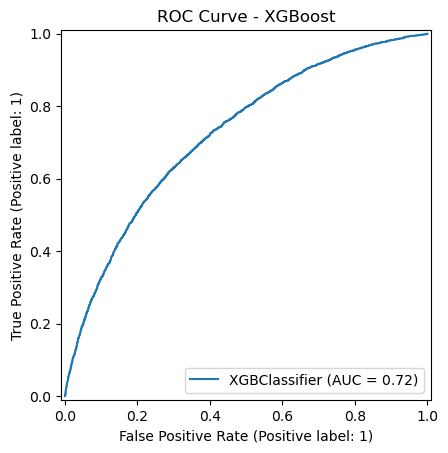

In [77]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)
import matplotlib.pyplot as plt

y_pred  = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - XGBoost"); plt.show()

RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.title("ROC Curve - XGBoost"); plt.show()


In [79]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

for thr in [0.50, 0.40, 0.35, 0.30, 0.25]:
    y_hat = (y_proba >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_hat, average="binary")
    print(f"thr={thr:.2f}  Precision={p:.3f}  Recall={r:.3f}  F1={f1:.3f}")


thr=0.50  Precision=0.341  Recall=0.638  F1=0.445
thr=0.40  Precision=0.292  Recall=0.780  F1=0.424
thr=0.35  Precision=0.271  Recall=0.840  F1=0.410
thr=0.30  Precision=0.256  Recall=0.891  F1=0.398
thr=0.25  Precision=0.243  Recall=0.925  F1=0.384


In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd


results = []


results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, log_reg.predict(X_test)),
    "Precision": precision_score(y_test, log_reg.predict(X_test)),
    "Recall": recall_score(y_test, log_reg.predict(X_test)),
    "F1": f1_score(y_test, log_reg.predict(X_test)),
    "ROC-AUC": roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])
})


results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, rf.predict(X_test)),
    "Precision": precision_score(y_test, rf.predict(X_test)),
    "Recall": recall_score(y_test, rf.predict(X_test)),
    "F1": f1_score(y_test, rf.predict(X_test)),
    "ROC-AUC": roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
})


results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, xgb_clf.predict(X_test)),
    "Precision": precision_score(y_test, xgb_clf.predict(X_test)),
    "Recall": recall_score(y_test, xgb_clf.predict(X_test)),
    "F1": f1_score(y_test, xgb_clf.predict(X_test)),
    "ROC-AUC": roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
})


comparison_df = pd.DataFrame(results)
print(comparison_df)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.661130   0.329746  0.669980  0.441967  0.726421
1        Random Forest  0.799989   0.503277  0.109060  0.179272  0.710682
2              XGBoost  0.680699   0.341226  0.638455  0.444752  0.724156


In [85]:
!pip install shap


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
    --------------------------------------- 10.2/545.3 kB ? eta -:--:--
   ---------- ----------------------------- 143.4/545.3 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------  542.7/545.3 kB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 545.3/545.3 kB 4.3 MB/s eta 0:00:00


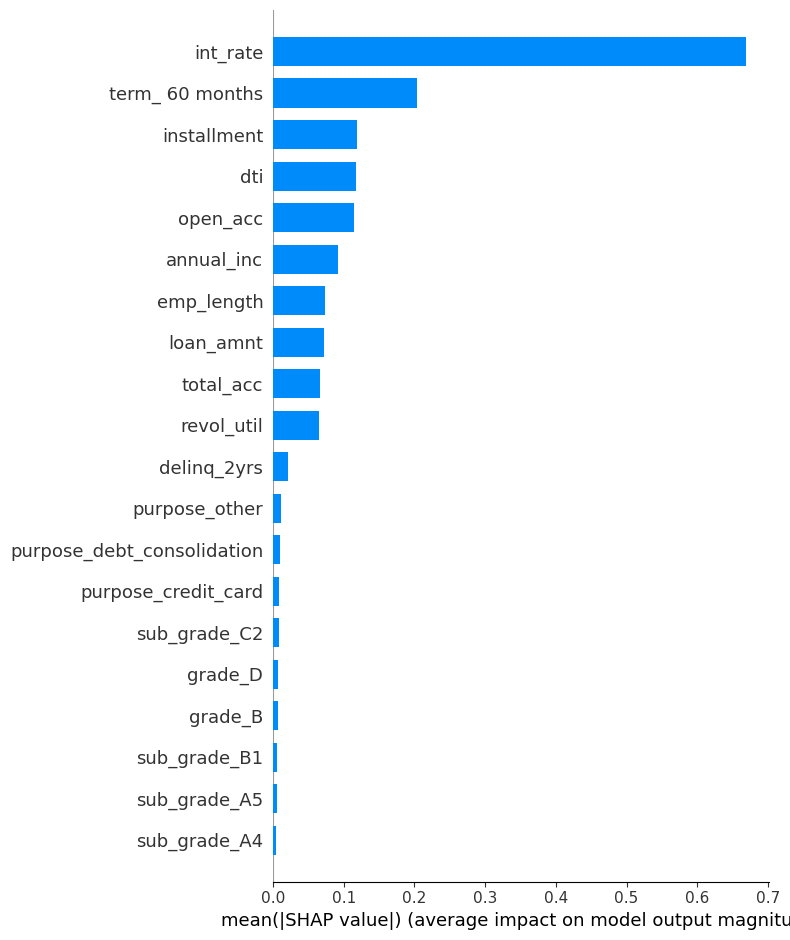

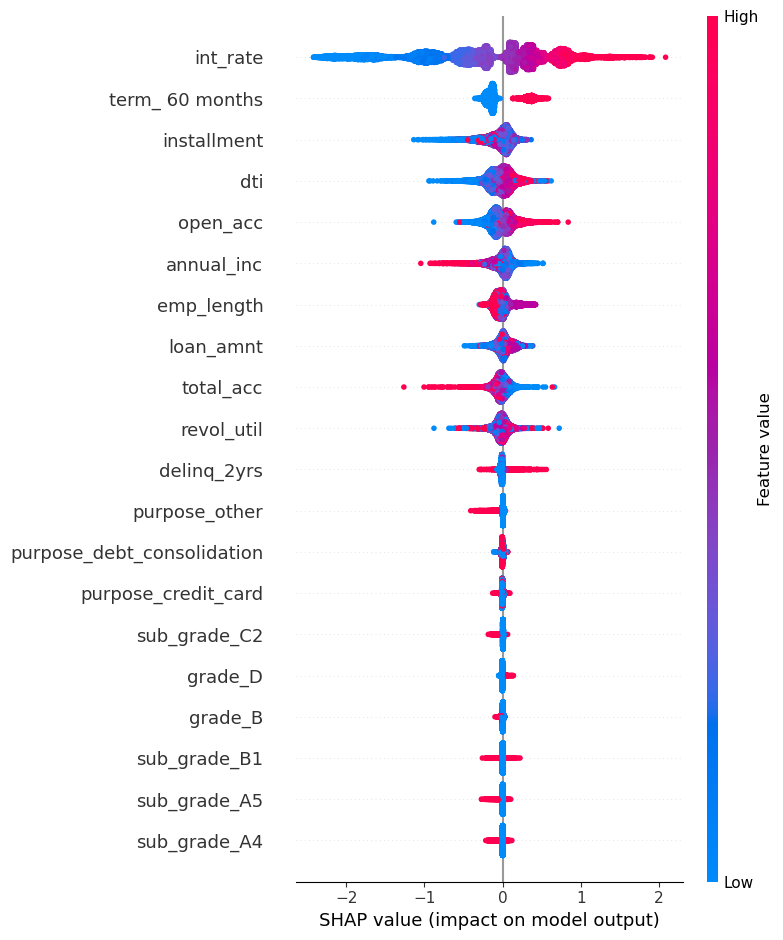

In [87]:
import shap

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)


In [89]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb


pos = y_train.sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos


param_grid = {
    "n_estimators": [300, 500, 800],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "scale_pos_weight": [scale_pos_weight, scale_pos_weight*0.8, scale_pos_weight*1.2]
}

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  
    scoring="roc_auc",  
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


In [91]:
search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)
print("Best AUC Score:", search.best_score_)
best_model = search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\yigit\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 3.9927572250230776, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best AUC Score: 0.7337279079869737


In [93]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.7302190353600204
              precision    recall  f1-score   support

           0       0.89      0.67      0.76     14058
           1       0.34      0.67      0.45      3521

    accuracy                           0.67     17579
   macro avg       0.61      0.67      0.60     17579
weighted avg       0.78      0.67      0.70     17579



In [95]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

for thr in [0.50, 0.40, 0.35, 0.30, 0.25]:
    y_hat = (y_proba >= thr).astype(int)
    p = precision_score(y_test, y_hat)
    r = recall_score(y_test, y_hat)
    f = f1_score(y_test, y_hat)
    print(f"thr={thr:.2f}  Precision={p:.3f}  Recall={r:.3f}  F1={f:.3f}")


thr=0.50  Precision=0.335  Recall=0.674  F1=0.448
thr=0.40  Precision=0.284  Recall=0.815  F1=0.422
thr=0.35  Precision=0.265  Recall=0.876  F1=0.407
thr=0.30  Precision=0.249  Recall=0.923  F1=0.393
thr=0.25  Precision=0.237  Recall=0.953  F1=0.379


In [97]:
!pip install mlflow


   ---------------------------------------- 0.0/26.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/26.4 MB 3.6 MB/s eta 0:00:08
    --------------------------------------- 0.5/26.4 MB 6.0 MB/s eta 0:00:05
   - -------------------------------------- 1.0/26.4 MB 8.1 MB/s eta 0:00:04
   -- ------------------------------------- 1.6/26.4 MB 9.2 MB/s eta 0:00:03
   --- ------------------------------------ 2.2/26.4 MB 10.1 MB/s eta 0:00:03
   ---- ----------------------------------- 2.8/26.4 MB 10.6 MB/s eta 0:00:03
   ----- ---------------------------------- 3.5/26.4 MB 11.2 MB/s eta 0:00:03
   ------ --------------------------------- 4.1/26.4 MB 11.4 MB/s eta 0:00:02
   ------ --------------------------------- 4.6/26.4 MB 11.3 MB/s eta 0:00:02
   ------- -------------------------------- 5.1/26.4 MB 11.6 MB/s eta 0:00:02
   -------- ------------------------------- 5.6/26.4 MB 11.1 MB/s eta 0:00:02
   --------- ------------------------------ 6.2/26.4 MB 11.3 MB/s eta 0:00:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.0.0 requires cryptography<43,>=41.0.5, but you have cryptography 45.0.7 which is incompatible.


In [99]:

from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

THRESHOLD = 0.40  # <- adjust if you prefer

y_proba = best_model.predict_proba(X_test)[:, 1]
y_hat   = (y_proba >= THRESHOLD).astype(int)

auc  = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_hat)
rec  = recall_score(y_test, y_hat)
f1   = f1_score(y_test, y_hat)
cm   = confusion_matrix(y_test, y_hat)

auc, prec, rec, f1, cm


(0.7302190353600204,
 0.2844400396432111,
 0.8151093439363817,
 0.4217177283079862,
 array([[6838, 7220],
        [ 651, 2870]], dtype=int64))

In [101]:
import joblib, json, matplotlib.pyplot as plt
import shap
from pathlib import Path

ART = Path("artifacts")
ART.mkdir(exist_ok=True, parents=True)


joblib.dump(best_model, ART/"xgb_model.joblib")
joblib.dump(scaler,     ART/"scaler.joblib")          
feature_order = list(X_test.columns)
json.dump(feature_order, open(ART/"feature_list.json","w"))
json.dump({"threshold": THRESHOLD}, open(ART/"threshold.json","w"))


fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix @thr={:.2f}".format(THRESHOLD))
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i,j),v in np.ndenumerate(cm): ax.text(j, i, int(v), ha='center', va='center')
fig.tight_layout(); fig.savefig(ART/"confusion_matrix.png", dpi=150); plt.close(fig)


explainer  = shap.TreeExplainer(best_model)
shap_vals  = explainer.shap_values(X_test)
shap.summary_plot(shap_vals, X_test, plot_type="bar", show=False)
plt.tight_layout(); plt.savefig(ART/"shap_global_bar.png", dpi=150); plt.close()


In [105]:
import mlflow, mlflow.sklearn


mlflow.set_tracking_uri("file:///C:/Users/yigit/mlruns")
mlflow.set_experiment("xgboost_risk_scoring")

with mlflow.start_run(run_name="xgb_tuned_v1") as run:
   
    mlflow.log_params(search.best_params_)
    mlflow.log_param("threshold", THRESHOLD)

    
    mlflow.log_metric("auc_test", auc)
    mlflow.log_metric("precision_at_thr", prec)
    mlflow.log_metric("recall_at_thr", rec)
    mlflow.log_metric("f1_at_thr", f1)

    
    mlflow.log_artifact(str(ART/"xgb_model.joblib"))
    mlflow.log_artifact(str(ART/"scaler.joblib"))
    mlflow.log_artifact(str(ART/"feature_list.json"))
    mlflow.log_artifact(str(ART/"threshold.json"))
    mlflow.log_artifact(str(ART/"confusion_matrix.png"))
    mlflow.log_artifact(str(ART/"shap_global_bar.png"))

    
    mlflow.sklearn.log_model(best_model, artifact_path="model", registered_model_name=None)

print("Logged run. Open MLflow UI with:  mlflow ui --port 5000")


2025/09/13 22:59:48 INFO mlflow.tracking.fluent: Experiment with name 'xgboost_risk_scoring' does not exist. Creating a new experiment.
2025/09/13 22:59:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/13 23:00:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged run. Open MLflow UI with:  mlflow ui --port 5000


In [107]:

import shap, joblib, json, pandas as pd

model = joblib.load("artifacts/xgb_model.joblib")
explainer = shap.TreeExplainer(model)
feature_order = json.load(open("artifacts/feature_list.json"))

def explain_one(df_row, top_k=5):
    sv = explainer.shap_values(df_row.values.reshape(1,-1))[0]
    pairs = sorted(zip(feature_order, sv), key=lambda t: abs(t[1]), reverse=True)[:top_k]
    return [{"feature": f, "impact": float(v)} for f, v in pairs]
